## Image classification with Convolutional Neural Networks
Welcome to the first week of the second deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.


### Introduction to our first task: 'Dogs vs Cats'
We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

Here is the dataset http://files.fast.ai/data/dogscats.zip. You can donwload it directly on your server by running the following line in your terminal. "wget http://files.fast.ai/data/dogscats.zip"

### First look at cat pictures

In [15]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

In [11]:
from os import listdir
from os.path import join
path = "/data/yinterian/dogscats/"
print(listdir(path))
print(listdir(join(path, 'valid')))

['sample', 'train', 'valid', 'models', 'test1', 'tmp']
['cats', 'dogs']


Our library will assume that you have a 'train' and 'valid' directories. It also assumes that each dir will have subdirs 'cats' and 'dogs'.

In [13]:
# Here are our validations cats
print(listdir(join(path, 'valid/cats')))

['cat.2266.jpg', 'cat.1288.jpg', 'cat.5335.jpg', 'cat.4648.jpg', 'cat.4689.jpg', 'cat.1460.jpg', 'cat.1199.jpg', 'cat.5449.jpg', 'cat.4142.jpg', 'cat.7283.jpg', 'cat.11225.jpg', 'cat.2860.jpg', 'cat.10806.jpg', 'cat.2044.jpg', 'cat.684.jpg', 'cat.8758.jpg', 'cat.3829.jpg', 'cat.2550.jpg', 'cat.12076.jpg', 'cat.12309.jpg', 'cat.11280.jpg', 'cat.11645.jpg', 'cat.11746.jpg', 'cat.11459.jpg', 'cat.8328.jpg', 'cat.5647.jpg', 'cat.11692.jpg', 'cat.6001.jpg', 'cat.1829.jpg', 'cat.3298.jpg', 'cat.10827.jpg', 'cat.10781.jpg', 'cat.12011.jpg', 'cat.11484.jpg', 'cat.9082.jpg', 'cat.6746.jpg', 'cat.1822.jpg', 'cat.9599.jpg', 'cat.6356.jpg', 'cat.980.jpg', 'cat.7723.jpg', 'cat.1690.jpg', 'cat.4288.jpg', 'cat.9584.jpg', 'cat.6367.jpg', 'cat.5770.jpg', 'cat.12079.jpg', 'cat.6449.jpg', 'cat.8665.jpg', 'cat.3939.jpg', 'cat.2325.jpg', 'cat.605.jpg', 'cat.3688.jpg', 'cat.11403.jpg', 'cat.7043.jpg', 'cat.5452.jpg', 'cat.3284.jpg', 'cat.2548.jpg', 'cat.6897.jpg', 'cat.1195.jpg', 'cat.10321.jpg', 'cat.361.j

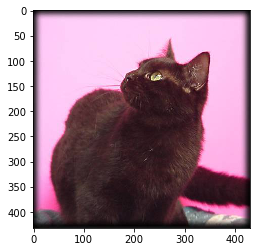

In [18]:
onecat = join(path, 'valid/cats/cat.8529.jpg')
img = mpimg.imread(onecat)
plt.imshow(img)

In [20]:
# Here is how the raw data looks like
print(img.shape)
img

(432, 431, 3)


array([[[ 3,  2,  7],
        [ 6,  5, 10],
        [10,  8, 13],
        ..., 
        [ 8,  8,  8],
        [ 6,  8,  7],
        [ 6,  8,  7]],

       [[ 5,  4,  9],
        [ 9,  7, 12],
        [12, 10, 15],
        ..., 
        [10, 10, 10],
        [ 8, 10,  9],
        [ 8, 10,  9]],

       [[ 8,  6, 11],
        [11,  9, 14],
        [14, 12, 17],
        ..., 
        [13, 13, 15],
        [11, 11, 11],
        [10, 10, 10]],

       ..., 
       [[ 6,  6,  6],
        [ 6,  6,  6],
        [ 7,  7,  7],
        ..., 
        [ 6,  6,  6],
        [ 6,  6,  6],
        [ 5,  5,  5]],

       [[ 6,  6,  4],
        [ 6,  6,  4],
        [ 7,  7,  5],
        ..., 
        [ 5,  5,  5],
        [ 4,  4,  4],
        [ 4,  4,  4]],

       [[ 6,  6,  4],
        [ 7,  7,  5],
        [ 8,  8,  6],
        ..., 
        [ 4,  4,  4],
        [ 3,  3,  3],
        [ 3,  1,  2]]], dtype=uint8)

### Our first model

Here we import the libraries we need.

In [46]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fast_gen import *
from conv_learner import *
from pt_models import *
from dataset_pt import *
from sgdr_pt import *

Terminology:
* <b>Stochastic Gradient descent (SGD)</b> is an optimization procedure that is used to find optimal parameters (weights) in machine learning models. More details [here](http://ruder.io/optimizing-gradient-descent/).
* Batch size (e.g. bs = 64) is the number of training examples in step of the SGD optimization. The higher the batch size, the more memory space you'll need.
* Resolution of the image (e.g. sz=64) is used for resizing the image before training. In deep learning images are often resized to a square of size szxsz. Many models come with a fixed input size. Resnet models can be trained with different sizes.
* A <b>pre-trained</b> model is a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, you use the model trained on other problem as a starting point. We used models trained with ImageNet (1.2 million images and 1000 classes.)
* Convolutional Neural Network is a type of Neural Network that builds state-of-the-art models for computer vision.

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. For a few lectures we are just going to be using models without getting too much into the details. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

In [38]:
bs=64; sz=64
f_model = resnet34
path = "/data/yinterian/dogscats/"

<b>tfms</b> stand for *transformations*. <b>tfms_from_model</b> takes care of resizing, *data augmentation*, image cropping and initial normalization. <b>ImageClassifierData.from_paths</b> reads data from a provided path and creates a dataset ready for training. 

In [39]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data_full = ImageClassifierData.from_paths(path, bs, tfms, test_name='test1')

The method <b>resize</b> creates a temporary file with resized images. This is for speeding up training.

In [24]:
data = data_full.resize(128, 'tmp') if sz<=90 else data_full

<b>ConvLearner.pretrained</b> builds *learner* that contains a pretrained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes but we need a model with two classes (cats and dogs). These weights of that layer are iniliatized randomly. The diagram below shows in an example how this is done. The layer "FC8" gets replaced with a new layer with 2 outputs. The top layers are fronzen while the new layer gets trained.

<img src="imgs/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [25]:
learn = ConvLearner.pretrained(f_model, data, ps=0.2)

In the figure above the layers represented by cubes are called the *convolutional layers* while the fatten looking layers are called *fully connected*. We could *cut* the convolutional layers from the fully connected layers. Let's call the model with convolutional layers the *top_model* and the fully connected model the *fc_model*. If we wanted to train just the weights in the fc_model a good strategy is to do the following: (1) for each image in your training data store the output of the top_model, (2) use the output from top_model as input to the fc_model to train the fully connected layers, (3) put together the top_model with the fc_model to get a full model. This strategy is equivalent to training the whole model but much faster.

The next line of code it telling our library to do exactly that.

In [26]:
learn.use_fc=True

Terminology:
* <b>Learning rate</b> determines how quickly or how slowly you want to update the weight parameters in gradient descent. Usually, you want to start with a large learning rate, and gradually decrease the learning rate as the training progresses. 

<b>learn.lr_find() </b> helps you find an optimal learning rate.

In [27]:
lrf=learn.lr_find()

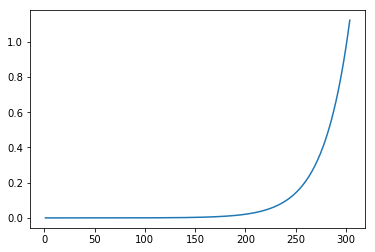

In [28]:
learn.sched.plot_lr()

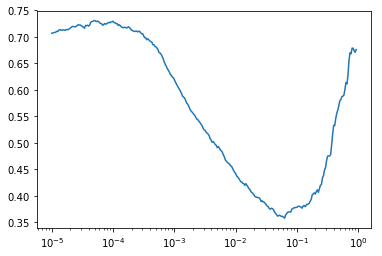

In [29]:
learn.sched.plot()

In [30]:
learn.fit(1e-2, 2)

[ 0.286369  0.239271  0.906738]


[ 0.257601  0.238977  0.901855]



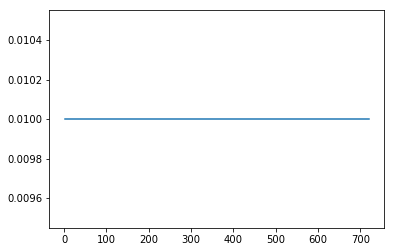

In [31]:
learn.sched.plot_lr()

In [32]:
learn.use_fc=False

In [33]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

[ 0.28355   0.226419  0.90918 ]


[ 0.267918  0.230327  0.904297]


[ 0.251107  0.223011  0.907715]


[ 0.269019  0.227529  0.907227]


[ 0.267296  0.221296  0.90918 ]


[ 0.253183  0.22363   0.906738]


[ 0.249974  0.217414  0.914062]



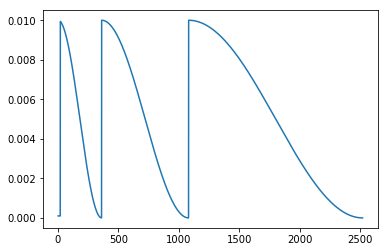

In [34]:
learn.sched.plot_lr()

In [35]:
learn.save('64_fc')

In [36]:
learn.freeze_to(6)

In [37]:
learn.fit(1e-2, 2, cycle_len=1)

[ 0.230263  0.186244  0.92334 ]


[ 0.191914  0.17275   0.931152]



In [38]:
lr=np.array([1e-3,3e-3,1e-2])

In [39]:
learn.unfreeze()

In [40]:
learn.fit(lr, 1)

[ 0.159248  0.157141  0.937988]



In [41]:
learn.load('64_fc')

In [42]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

[ 0.251741  0.204349  0.91748 ]


[ 0.193032  0.16722   0.937012]


[ 0.158678  0.155727  0.935547]


[ 0.162044  0.151961  0.941406]


[ 0.123913  0.143349  0.943848]


[ 0.100975  0.144214  0.945312]


[ 0.093923  0.146348  0.947754]



In [28]:
accuracy(*learn.TTA())

0.95899999999999996

### 299x299

In [47]:
sz=299;bs=64
f_model = resnet34
path = "/data/yinterian/dogscats/"

In [48]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(path, bs, tfms, test_name='test1')

In [49]:
learn = ConvLearner.pretrained(f_model, data)

In [50]:
learn.use_fc=True

In [51]:
learn.fit(1e-2, 2, cycle_len=1)

[ 0.040155  0.024559  0.992676]


[ 0.046357  0.024911  0.992188]



In [52]:
learn.use_fc=False

In [49]:
learn.fit(1e-2, 1, cycle_len=1)

[ 0.040759  0.023743  0.993164]



In [36]:
accuracy(*learn.TTA())

0.99350000000000005

In [37]:
learn.save('299_fc_no')

In [50]:
lr=np.array([1e-4,1e-3,1e-2])

In [51]:
learn.unfreeze()

In [52]:
learn.fit(lr, 6, cycle_len=2)

[ 0.040478  0.022282  0.990234]


[ 0.029373  0.018943  0.994629]


[ 0.032071  0.018834  0.991699]


[ 0.029316  0.017413  0.993652]


[ 0.033798  0.019044  0.992188]


[ 0.023341  0.016055  0.994141]


[ 0.021911  0.014912  0.994629]


[ 0.017066  0.014338  0.995117]


[ 0.029317  0.016678  0.994141]


[ 0.013211  0.016578  0.994141]


[ 0.012513  0.018197  0.994629]


[ 0.014352  0.017431  0.994141]



In [ ]:
accuracy(learn.TTA(), data.val_y)

In [54]:
learn.save('299_no')

In [ ]:
learn.fit(lr/5, 4, cycle_len=2)

In [ ]:
accuracy(learn.TTA(), data.val_y)

### Class Saliency Visualisation

In [21]:
from IPython.display import display, Math, Latex

Our model visualization is a version of this.
[script](https://github.com/leelabcnbc/cnnvis-pytorch/blob/master/test.ipynb). The details of this approach are descriped in this [paper](https://arxiv.org/pdf/1312.6034.pdf).

Given an image $I_0$, a class $c$, and a classification ConvNet with the class score function $Sc(I)$, we would like to rank the pixels of $I_0$ based on their influence on the score $Sc(I_0)$.

In [33]:
bs=1
f_model = resnet34
path = "/data/yinterian/dogscats/"
sz=299
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(path, bs, tfms, test_name='test1')
learn = ConvLearner.pretrained(f_model, data)
learn.load('299_no')

In [156]:
# to get the first element of the validation data
x, y = data.val_dl.dataset[5]
model = learn.model
denorm = tfms[0].denorm
x2 = np.rollaxis(x, 0, 3)
x_org = denorm(x2)

In [157]:
print(x.shape, x2.shape, x_org.shape)

(3, 299, 299) (299, 299, 3) (299, 299, 3)


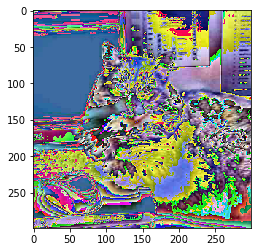

In [158]:
plt.imshow(x2)

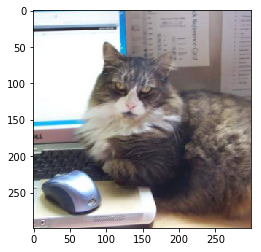

In [159]:
plt.imshow(x_org)

In [160]:
_ = model.eval()

In [161]:
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor

In [162]:
x.shape

(3, 299, 299)

In [163]:
xx = T(x).unsqueeze(0)
xx.size()
xx = xx.contiguous()

In [164]:
input_img = Parameter(xx.cuda(async=True), requires_grad=True)

In [165]:
if input_img.grad is not None:
    input_img.grad.data.zero_()

In [166]:
model.zero_grad()

In [167]:
#input_img = input_img.unsqueeze(0)

In [168]:
raw_score = model(input_img)

In [169]:
raw_score_numpy = raw_score.data.cpu().numpy()
print(np.around(np.exp(raw_score_numpy), decimals=4))

[[ 1.  0.]]


In [170]:
def show_images(img_original, saliency, title):
    # convert from c01 to 01c
    print(saliency.min(), saliency.max(), saliency.mean(), saliency.std())
    saliency = saliency[::-1]  # to BGR
    saliency = saliency.transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(np.asarray(img_original))
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.suptitle(title)
    plt.show()

In [171]:
loss = raw_score.sum()

In [172]:
loss.backward(retain_variables=True)

/home/yinterian/anaconda/lib/python3.6/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


-0.459269 0.376274 -4.71648e-06 0.0246497


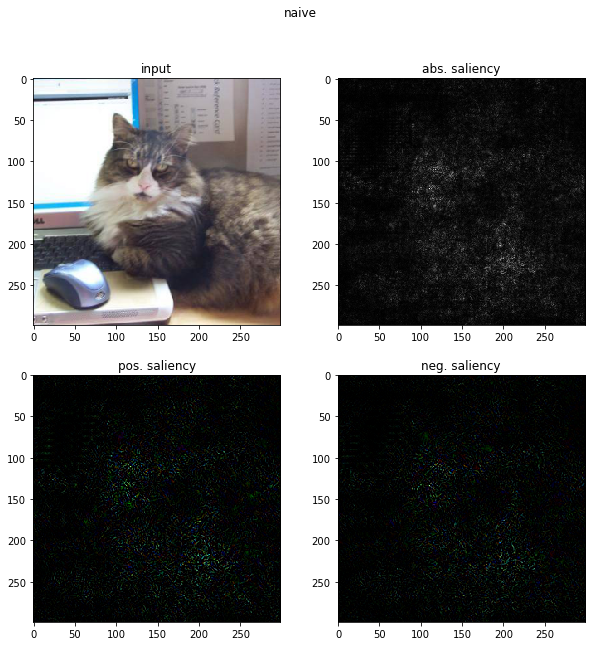

In [173]:
show_images(x_org, input_img.grad.data.cpu().numpy()[0], 'naive')


## End

In [ ]:
tfm=Transforms(64, [Scale(64)], rand_crop=True)
data = ClassifierData.from_paths(data.path, 2, (tfm, tfm))
x,y=next(iter(ds.val_dl))
plt.imshow(np.rollaxis(x[0].numpy(),0,3));

In [ ]:
im=PIL.Image.open(data_full.path+'/'+data_full.val_dl.dataset.fnames[0])
plt.imshow(cv2.resize(np.array(im), (64,64), interpolation=cv2.INTER_NEAREST));

In [ ]:
im=PIL.Image.open(data_full.path+'/'+data_full.val_dl.dataset.fnames[0])
plt.imshow(cv2.resize(np.array(im), (64,64)));